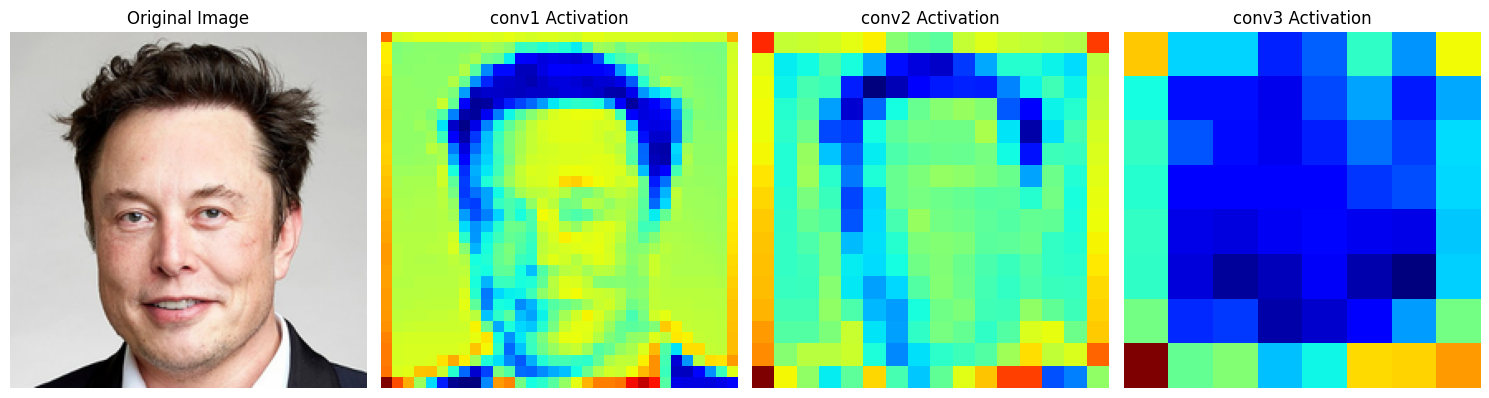

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define the CNN architecture
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 7)  # 7 emotion classes

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Store intermediate activations
        self.activations = {}

        x = self.pool(F.relu(self.conv1(x)))
        self.activations['conv1'] = x

        x = self.pool(F.relu(self.conv2(x)))
        self.activations['conv2'] = x

        x = self.pool(F.relu(self.conv3(x)))
        self.activations['conv3'] = x

        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Function to visualize activation maps
def visualize_activation_maps(model, image_path):
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])

    image = Image.open(image_path)
    input_tensor = transform(image).unsqueeze(0)

    # Forward pass
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    # Get activation maps
    activation_maps = {}
    for layer_name, activations in model.activations.items():
        # Take mean across channels
        activation_map = torch.mean(activations[0], dim=0).numpy()

        # Normalize for visualization
        activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
        activation_maps[layer_name] = activation_map

    # Visualize
    plt.figure(figsize=(15, 5))

    plt.subplot(141)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    for idx, (layer_name, act_map) in enumerate(activation_maps.items()):
        plt.subplot(1, 4, idx + 2)
        plt.imshow(act_map, cmap='jet')
        plt.title(f'{layer_name} Activation')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
model = EmotionCNN()
# Load pretrained weights (you would need to train the model first)
# model.load_state_dict(torch.load('emotion_model.pth'))

# Visualize activation maps for a sample image
visualize_activation_maps(model, '/content/elon.png')

In [3]:
def visualize_specific_filters(model, image_path, layer_name='conv1', n_filters=8):
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])

    image = Image.open(image_path)
    input_tensor = transform(image).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    # Get activations for specific layer
    activations = model.activations[layer_name][0]

    # Visualize specific filters
    plt.figure(figsize=(20, 4))

    plt.subplot(1, n_filters + 1, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    for i in range(n_filters):
        plt.subplot(1, n_filters + 1, i + 2)
        plt.imshow(activations[i].numpy(), cmap='jet')
        plt.title(f'Filter {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

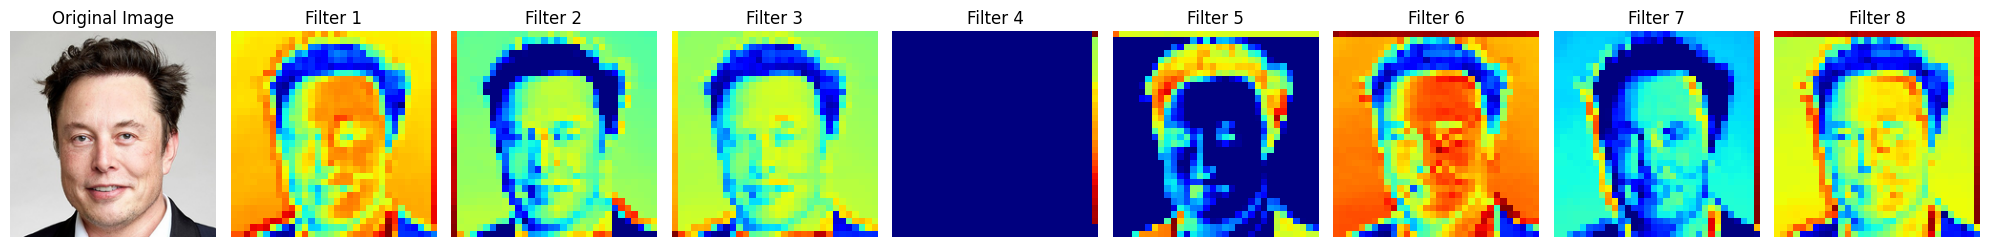

In [4]:
visualize_specific_filters(model, '/content/elon.png')